# Problema de Negocio (Enunciado de Kaggle)

### Descripción

Lucas ha decidido cambiar de aires y, por eso, ha comprado una tienda de portátiles. Sin embargo, su única especialidad es Data Science, por lo que ha decidido crear un modelo de ML para establecer los mejores precios.

¿Podrías ayudar a Lucas a mejorar ese modelo?

### Evaluación

Error de raíz cuadrada media (RMSE) es la desviación estándar de los valores residuales (errores de predicción). Los valores residuales son una medida de la distancia de los puntos de datos de la línea de regresión.

RMSE es una medida de cuál es el nivel de dispersión de estos valores residuales. En otras palabras, le indica el nivel de concentración de los datos en la línea de mejor ajuste.

$$RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{d_i - f_i}{\sigma_i}\right)^2}$$

### Referencia

[Iván Cordero. (2024). Plan de negocio – DataTops®. Kaggle.](https://kaggle.com/competitions/datatops)


# Estrategia 1

Utilizar un regresor que ya admite variables categóricas en su entrada, como es `CatBoost`.

# 0. Librerías

In [1]:
import os
import pickle
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

from utils import datascience as ds
from utils import machinelearningtools as ml
from utils import vizdatatools as viz
from utils.functions import kaggle_checker

# Establecer un estilo moderno con Seaborn
sns.set_theme(style="darkgrid", palette='bright')


# 1. Entendiendo el problema de negocio

El principal objetivo del proyecto es crear un modelo de Machine Learning que permita a Lucas:

- Establecer precios precisos: Determinar el precio de venta ideal para cada portátil, considerando sus características técnicas.
- El rendimiento del modelo será evaluado utilizando el Error Cuadrático Medio (RMSE).
- Contamos con dos sets de trabajo:
    - `train.csv`: set de *train* sobre el que evaluaré las métricas y con el que entrenaré el modelo.
    - `test.csv`: set de *test* con el que predecir los precios de los portátiles, cuyo resultado (*submission*) se cargará a Kaggle.


# 2. Obtener datos y un primer vistazo.

In [2]:
# Para que funcione necesitas bajarte los archivos de datos de Kaggle 
df_train = pd.read_csv(r'data/train.csv', index_col=0)
# df_train.index.name = None

df_train.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_in_euros
laptop_ID,,,,,,,,,,,,
755,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.86kg,539.00
618,Dell,Inspiron 7559,Gaming,15.6,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,16GB,1TB HDD,Nvidia GeForce GTX 960<U+039C>,Windows 10,2.59kg,879.01
909,HP,ProBook 450,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,Nvidia GeForce 930MX,Windows 10,2.04kg,900.00
2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
286,Dell,Inspiron 3567,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,AMD Radeon R5 M430,Linux,2.25kg,428.00


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 912 entries, 755 to 229
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           912 non-null    object 
 1   Product           912 non-null    object 
 2   TypeName          912 non-null    object 
 3   Inches            912 non-null    float64
 4   ScreenResolution  912 non-null    object 
 5   Cpu               912 non-null    object 
 6   Ram               912 non-null    object 
 7   Memory            912 non-null    object 
 8   Gpu               912 non-null    object 
 9   OpSys             912 non-null    object 
 10  Weight            912 non-null    object 
 11  Price_in_euros    912 non-null    float64
dtypes: float64(2), object(10)
memory usage: 92.6+ KB


In [4]:
for col in df_train.columns:
    print(col)
    display(df_train[col].unique())

Company


array(['HP', 'Dell', 'Apple', 'Lenovo', 'MSI', 'Toshiba', 'Acer', 'Chuwi',
       'Asus', 'Huawei', 'Razer', 'Mediacom', 'Google', 'Samsung',
       'Xiaomi', 'Microsoft', 'Vero', 'LG', 'Fujitsu'], dtype=object)

Product


array(['250 G6', 'Inspiron 7559', 'ProBook 450', 'Macbook Air',
       'Inspiron 3567', 'ProBook 650', 'Envy 13-AD007nv',
       'IdeaPad 320-15IKB', 'GL72M 7REX', 'Thinkpad T570', 'MacBook Pro',
       'Ideapad 320-15IKBR', 'IdeaPad 320-15IAP', 'Portege Z30-C-16P',
       'Latitude 5590', 'IdeaPad 110-15IBR', 'GP72MVR 7RFX',
       'ThinkPad X1', 'GL62 6QF', 'Portege X30-D-10X', 'Chromebook 11',
       'Inspiron 5567', 'IdeaPad 510s-14IKB', 'LapBook 15.6"',
       'GE62 Apache', 'ZBook 17', 'Inspiron 7567', 'VivoBook Pro',
       'Pro P2540UA-XO0198T', 'Thinkpad 13', 'MateBook X', 'Vostro 5568',
       '250 G5', 'EliteBook 840', 'Inspiron 7570', 'IdeaPad Y700-15ISK',
       'ThinkPad P51', 'IdeaPad 320-15IKBN', 'Portege Z30-C-1CV',
       'XPS 13', 'IdeaPad 510-15IKB',
       '15-bs002nv (i3-6006U/4GB/128GB/FHD/W10)', 'Blade Pro',
       'Rog Strix', 'ProBook 440', '15-AC110nv (i7-6500U/6GB/1TB/Radeon',
       'Probook 440', 'FX753VD-GC071T (i7-7700HQ/8GB/1TB/GeForce',
       'GS73VR 

TypeName


array(['Notebook', 'Gaming', 'Ultrabook', 'Workstation', 'Netbook',
       '2 in 1 Convertible'], dtype=object)

Inches


array([15.6, 13.3, 14. , 17.3, 11.6, 13. , 12. , 10.1, 12.5, 12.3, 15. ,
       14.1, 13.5, 11.3, 13.9, 15.4, 18.4])

ScreenResolution


array(['Full HD 1920x1080', '1440x900', '1366x768',
       'IPS Panel Full HD 1920x1080', 'IPS Panel 4K Ultra HD 3840x2160',
       'IPS Panel Retina Display 2560x1600', 'Touchscreen 1366x768',
       'IPS Panel Quad HD+ 2560x1440', 'IPS Panel 1366x768',
       'Full HD / Touchscreen 1920x1080', 'IPS Panel Full HD 2160x1440',
       'Quad HD+ 3200x1800', '4K Ultra HD / Touchscreen 3840x2160',
       'IPS Panel Retina Display 2304x1440',
       'IPS Panel Full HD / Touchscreen 1920x1080',
       'IPS Panel Touchscreen 1920x1200',
       'IPS Panel Touchscreen 2560x1440', 'Touchscreen 2400x1600',
       'IPS Panel 4K Ultra HD / Touchscreen 3840x2160',
       'IPS Panel Full HD 2560x1440', 'Quad HD+ / Touchscreen 3200x1800',
       '4K Ultra HD 3840x2160',
       'IPS Panel Quad HD+ / Touchscreen 3200x1800',
       'Touchscreen 2256x1504', '1600x900',
       'IPS Panel Touchscreen 1366x768',
       'Touchscreen / Quad HD+ 3200x1800', 'IPS Panel 2560x1440',
       'IPS Panel Quad HD+ 3200x

Cpu


array(['Intel Core i3 6006U 2GHz', 'Intel Core i7 6700HQ 2.6GHz',
       'Intel Core i7 7500U 2.7GHz', 'Intel Core i5 1.8GHz',
       'Intel Core i3 6006U 2.0GHz', 'Intel Core i5 7300U 2.6GHz',
       'Intel Core i5 7200U 2.5GHz', 'Intel Core i3 7100U 2.4GHz',
       'Intel Core i7 7700HQ 2.8GHz', 'Intel Core i7 7600U 2.8GHz',
       'Intel Core i5 2.9GHz', 'Intel Core i7 8550U 1.8GHz',
       'Intel Pentium Quad Core N4200 1.1GHz',
       'Intel Core i7 6500U 2.5GHz', 'Intel Core i7 8650U 1.9GHz',
       'Intel Celeron Quad Core N3710 1.6GHz',
       'Intel Celeron Dual Core N3060 1.6GHz',
       'Intel Atom x5-Z8300 1.44GHz', 'Intel Core i5 7300HQ 2.5GHz',
       'Intel Pentium Quad Core N3710 1.6GHz',
       'Intel Core i5 6200U 2.3GHz', 'Intel Core i5 8250U 1.6GHz',
       'AMD Ryzen 1700 3GHz', 'Intel Core i7 7820HK 2.9GHz',
       'Intel Core i5 1.3GHz', 'Intel Pentium Quad Core N3700 1.6GHz',
       'AMD A9-Series A9-9420 3GHz', 'Intel Core i7 7560U 2.4GHz',
       'Intel Core i

Ram


array(['8GB', '16GB', '4GB', '12GB', '32GB', '6GB', '2GB', '64GB', '24GB'],
      dtype=object)

Memory


array(['256GB SSD', '1TB HDD', '128GB Flash Storage',
       '128GB SSD +  1TB HDD', '512GB SSD', '500GB HDD',
       '256GB SSD +  256GB SSD', '128GB SSD', '32GB Flash Storage',
       '64GB Flash Storage', '1.0TB Hybrid', '2TB HDD',
       '256GB Flash Storage', '256GB SSD +  1TB HDD', '180GB SSD',
       '16GB Flash Storage', '1TB SSD', '256GB SSD +  2TB HDD',
       '32GB SSD', '1TB SSD +  1TB HDD', '128GB SSD +  2TB HDD',
       '512GB SSD +  1TB HDD', '512GB SSD +  512GB SSD',
       '512GB SSD +  256GB SSD', '16GB SSD',
       '64GB Flash Storage +  1TB HDD', '64GB SSD', '128GB HDD',
       '240GB SSD', '512GB SSD +  2TB HDD', '508GB Hybrid', '8GB SSD',
       '256GB SSD +  500GB HDD', '1.0TB HDD', '512GB Flash Storage',
       '1TB HDD +  1TB HDD', '32GB HDD'], dtype=object)

Gpu


array(['Intel HD Graphics 520', 'Nvidia GeForce GTX 960<U+039C>',
       'Nvidia GeForce 930MX', 'Intel HD Graphics 6000',
       'AMD Radeon R5 M430', 'Intel HD Graphics 620',
       'Nvidia GeForce 940MX', 'Nvidia GeForce GTX 1050 Ti',
       'Intel Iris Graphics 550', 'Intel HD Graphics 505',
       'Intel UHD Graphics 620', 'Intel HD Graphics 405',
       'Nvidia GeForce GTX 1060', 'Nvidia GeForce GTX 960M',
       'Intel HD Graphics 400', 'AMD Radeon R7 M445',
       'AMD Radeon R7 M460', 'Intel HD Graphics', 'AMD FirePro W6150M',
       'Nvidia GeForce GTX 1050', 'Nvidia Quadro M1200',
       'AMD Radeon RX 580', 'Nvidia GeForce GTX 1080',
       'AMD Radeon R5 M330', 'Nvidia GeForce GTX 1070',
       'Intel HD Graphics 615', 'AMD Radeon 530', 'AMD Radeon 520',
       'Nvidia Quadro M620', 'Intel Iris Plus Graphics 640',
       'Nvidia Quadro M500M', 'Intel HD Graphics 510',
       'Intel Iris Plus Graphics 650', 'Nvidia GeForce 920MX ',
       'Intel HD Graphics 500', 'AMD Radeo

OpSys


array(['Windows 10', 'macOS', 'Linux', 'No OS', 'Chrome OS', 'Windows 7',
       'Android', 'Windows 10 S', 'Mac OS X'], dtype=object)

Weight


array(['1.86kg', '2.59kg', '2.04kg', '1.34kg', '2.25kg', '2.31kg',
       '1.32kg', '2.2kg', '2.7kg', '2.3kg', '1.37kg', '1.2kg', '1.88kg',
       '1.17kg', '1.05kg', '1.35kg', '1.5kg', '1.89kg', '2.4kg', '3.0kg',
       '2.65kg', '1.99kg', '2.37kg', '1.4kg', '2.36kg', '2.18kg',
       '1.96kg', '1.54kg', '3.14kg', '1.9kg', '1.13kg', '2.6kg', '2.67kg',
       '1.3kg', '1.91kg', '1.95kg', '3.25kg', '1.64kg', '1.44kg',
       '1.26kg', '3.49kg', '2.19kg', '1.63kg', '3kg', '2.43kg', '0.92kg',
       '2.1kg', '2.5kg', '1.48kg', '1.43kg', '2.06kg', '1.23kg', '1.8kg',
       '1.45kg', '1.93kg', '2.32kg', '0.69kg', '1.27kg', '1.25kg',
       '3.35kg', '2.56kg', '2.45kg', '1.47kg', '4.5kg', '2.0kg', '1.36kg',
       '1.1kg', '1.71kg', '1.21kg', '1.7kg', '1.94kg', '1.14kg', '1.6kg',
       '1.29kg', '2.05kg', '1.49kg', '4.36kg', '2.62kg', '2.21kg',
       '1.84kg', '2.17kg', '1.16kg', '2kg', '2.29kg', '2.9kg', '2.8kg',
       '1.65kg', '3.78kg', '2.73kg', '1.252kg', '0.98kg', '2.20kg',
       '

Price_in_euros


array([ 539.  ,  879.01,  900.  ,  898.94,  428.  , 1124.  ,  699.  ,
        499.  , 1348.48, 2445.  , 1958.9 ,  609.  ,  344.  , 1747.  ,
       1298.  ,  329.  , 1409.  , 1686.64, 1169.  , 1285.  ,  355.  ,
        859.01,  799.  ,  244.99, 1229.  , 2899.  ,  949.  , 1350.  ,
        398.99, 1010.  , 1349.  ,  557.37,  836.  ,  500.  , 1000.  ,
       1907.99,  299.  , 1049.  , 1875.  , 1272.  , 1925.  ,  597.  ,
       1195.  , 1268.  ,  709.  ,  485.  ,  439.  , 2199.  , 1049.26,
        735.  ,  295.  , 6099.  ,  764.  , 1084.  , 1187.  , 2449.  ,
        444.  ,  324.  , 1510.  ,  745.  , 1799.  ,  393.49, 1292.  ,
       1189.  , 1513.  ,  650.  , 1763.  , 1379.  , 2050.38,  375.  ,
       1962.99, 1426.66,  589.52, 1072.  ,  549.  , 2040.  , 2339.  ,
        459.  ,  349.  ,  819.  , 1185.43, 1249.26,  255.  ,  465.  ,
        980.  , 1579.  ,  479.  , 1713.49, 2349.  , 1207.  , 1584.  ,
       1049.6 ,  589.  , 1495.  , 1144.5 , 1949.  , 1943.  , 1096.  ,
        229.  , 1149

Tenía la esperanza de poder encontrar en "ScreenResolution" y/o en "Memory" clases que tuvieran la misma información y que se pudieran agrupar, pero parece que están bastante bien escogidas todas las columna categóricas y no hay redundancias.

In [5]:
ds.get_cardinality(df_train, threshold_categorical=38, threshold_continuous=30.0)

pandas.DataFrame shape:  (912, 12)


,Card,%_Card,NaN_Values,%_NaN_Values,Type,Class
Company,19,2.083333,0,0.0,object,Categoric
Product,480,52.631579,0,0.0,object,Numeric - Continuous
TypeName,6,0.657895,0,0.0,object,Categoric
Inches,17,1.864035,0,0.0,float64,Categoric
ScreenResolution,36,3.947368,0,0.0,object,Categoric
Cpu,107,11.732456,0,0.0,object,Numeric - Discrete
Ram,9,0.986842,0,0.0,object,Categoric
Memory,37,4.057018,0,0.0,object,Categoric
Gpu,93,10.197368,0,0.0,object,Numeric - Discrete
OpSys,9,0.986842,0,0.0,object,Categoric


Estoy bastante de acuerdo con la tabla anterior en la propuestas de clases (entre categóricas y numéricas). Voy a considerar como categóricas aqullas features que tengan una cardinalidad porcentual inferior al 5%. Además voy a intentar beneficiarme de que es un dataset compuesto de demasiadas columnas "object".

Es bueno ver que no hay valores missing.

Es un claro problema de regresión. El *target* es "Price_in_euros".

# 3. Split de train y validation

Hago esta separación desde el principio para no contaminar los datos.

Aunque antes elimino la columna "Product" porque tiene una cardinalidad tan alta que apenas aporta información.

In [6]:
# Eliminar "Product"
df_train.drop(columns=['Product'], inplace=True)

In [7]:
# Train-Test Split
train_set, valid_set = train_test_split(df_train, test_size=0.2)

# Target para la regresión
target = 'Price_in_euros'

print(train_set.shape)
print(valid_set.shape)

(729, 11)
(183, 11)


# 4. Mini-EDA

## 4.1 Transformaciones

Hay dos columnas que son fácilmente transformables a numéricas: "Ram" y "Weight", simplement eliminando algunos caractéres. Voy a tranformarlas, manteniendo la nomenclatura que usa el dataset, y eliminar las originales pues son redundantes.

In [8]:
# Transformar las columnas "Ram" y "Weight" a numéricas y eliminar las originales
train_set['RamGB'] = train_set['Ram'].str.replace('GB', '').astype(int)
train_set["WeightKg"] = train_set['Weight'].str.replace('kg', '').astype(float)
train_set.drop(['Ram', 'Weight'], axis=1, inplace=True)

valid_set['RamGB'] = valid_set['Ram'].str.replace('GB', '').astype(int)
valid_set["WeightKg"] = valid_set['Weight'].str.replace('kg', '').astype(float)
valid_set.drop(['Ram', 'Weight'], axis=1, inplace=True)

In [9]:
train_set.describe()

,Inches,Price_in_euros,RamGB,WeightKg
count,729.000000,729.000000,729.000000,729.000000
mean,14.968176,1108.990905,8.161866,2.021321
std,1.440487,698.798610,4.793669,0.670444
min,10.100000,174.000000,2.000000,0.690000
25%,14.000000,579.000000,4.000000,1.490000
50%,15.600000,979.000000,8.000000,2.020000
75%,15.600000,1479.000000,8.000000,2.300000
max,18.400000,6099.000000,32.000000,4.700000


## 4.2 Distribución del target

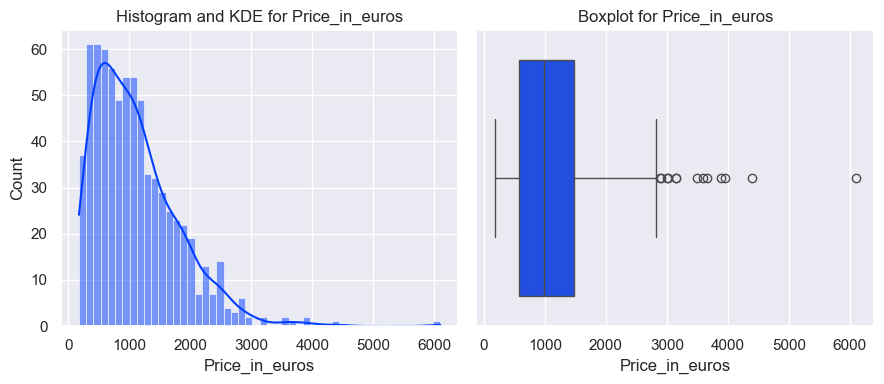

In [10]:
# Crear figura y subgráficas
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

# Graficar el histograma con KDE en la primera subgráfica
sns.histplot(train_set[target], kde=True, bins=50, ax=axs[0])
axs[0].set_title(f'Histogram and KDE for {target}')
axs[0].set_xlabel(target)

# Graficar el boxplot horizontal en la segunda subgráfica
sns.boxplot(x=train_set[target], ax=axs[1], orient='h')
axs[1].set_title(f'Boxplot for {target}')
axs[1].set_xlabel(target)

# Ajustar el layout
plt.tight_layout()
plt.show()


Hay varios valores outliers por arriba, que si los dejo en el modelo puede que modifiquen la métrica que estoy buscando. Los voy a eliminar a riesgo de no aprender nada de los ordenadores más caros del set.

In [11]:
# Calcular los cuartiles y el IQR
Q1 = train_set[target].quantile(0.25)
Q3 = train_set[target].quantile(0.75)
IQR = Q3 - Q1

# Definir límite superior
upper_bound = Q3 + 1.5 * IQR
print('Precio límite de los outliers:', upper_bound, '€.')

Precio límite de los outliers: 2829.0 €.


Viendo el KDE no voy a ser tan estricto como eliminar los outliers que justo caigan en el "upper bound", si no que voy a darle un margen un poco por encima.

Con un filtro (upper_limit) en 3500 € tan solo voy a dejar fuera 5 muestras, de las 729.

Ojo porque este filtro solo lo voy a aplicar en el *train_set*, porque en el test me pueden venir ordenadores de cualquier precio.

In [12]:
# upper_limit = 3500

# Solo dejo fuera del set 5 valores.
# display(train_set[train_set[target] >= upper_limit])

# Filtro train_set eliminando lo valores de los outliers. 
# train_set = train_set[~(train_set[target] >= upper_limit)]
# train_set.describe()

<Axes: xlabel='Price_in_euros', ylabel='Count'>

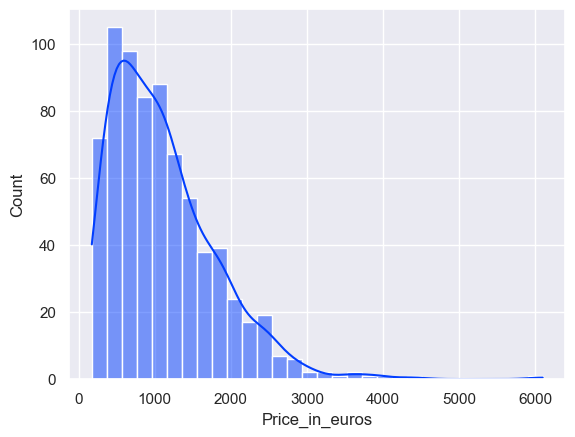

In [13]:
# Nueva densidad de probabilidad (tras eliminar outliers)
sns.histplot(train_set[target], kde=True)

No tiene una mala distribución el target, pero seguro que se puede mejorar...

A continuación muestro dos transformaciones no lineales que se pueden emplear en el target (como son la logaritmica y la raíz cuadrada). Sin embargo, y para estos primeros modelos `no voy a hacer ninguna transformación.` Seguramente en futuros modelos sí lo pruebe.

<Axes: xlabel='log_price_euros', ylabel='Count'>

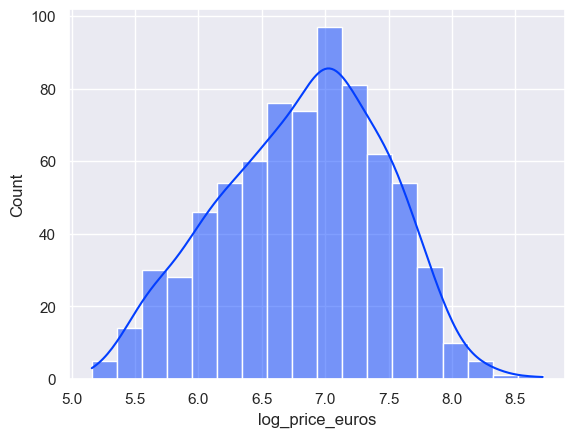

In [14]:
# Transformación logarítmica
train_set['log_price_euros'] = np.log(train_set['Price_in_euros'])
valid_set['log_price_euros'] = np.log(valid_set['Price_in_euros'])

sns.histplot(train_set['log_price_euros'], kde=True)


<Axes: xlabel='Price_in_euros', ylabel='Count'>

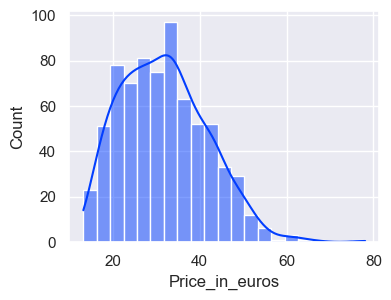

In [15]:
# Transformación raíz cuadrada.
plt.figure(figsize=(4, 3))
sns.histplot(np.sqrt(train_set[target]), kde=True)

In [16]:
# Eliminar el target original
train_set.drop(['Price_in_euros'], axis=1, inplace=True)
valid_set.drop(['Price_in_euros'], axis=1, inplace=True)

## 4.3 Análisis bivariante

Voy a inspeccionar visualmente aquellas variables en las que se pueda ver algo.

Definamos primero las variables categóricas de las numéricas.

In [17]:
# Definir variables numéricas, categóricas y categóricas con alta cardinalidad
target = 'log_price_euros'
num_features = ['WeightKg']
cat_features_high_card = ['Cpu', 'Gpu']
cat_features = [col for col in train_set.columns.to_list() if col not in ([target] + num_features)]

print(target)
print(num_features)
print(cat_features_high_card)
print(cat_features)


log_price_euros
['WeightKg']
['Cpu', 'Gpu']
['Company', 'TypeName', 'Inches', 'ScreenResolution', 'Cpu', 'Memory', 'Gpu', 'OpSys', 'RamGB']


#### Inspección de las variables categóricas.


In [18]:
cat_max_nunique = 0  # Variable para almacenar el máximo número de valores únicos

for feature in [feat for feat in cat_features if feat not in cat_features_high_card]:
    unique_values = train_set[feature].nunique()
    print(f'{feature}: {unique_values} valores únicos')
        
    # Actualizar el valor máximo si el actual es mayor
    if unique_values > cat_max_nunique:
        cat_max_nunique = unique_values

print(f'El número más alto de valores únicos es: {cat_max_nunique}')


Company: 19 valores únicos
TypeName: 6 valores únicos
Inches: 16 valores únicos
ScreenResolution: 36 valores únicos
Memory: 36 valores únicos
OpSys: 9 valores únicos
RamGB: 8 valores únicos
El número más alto de valores únicos es: 36


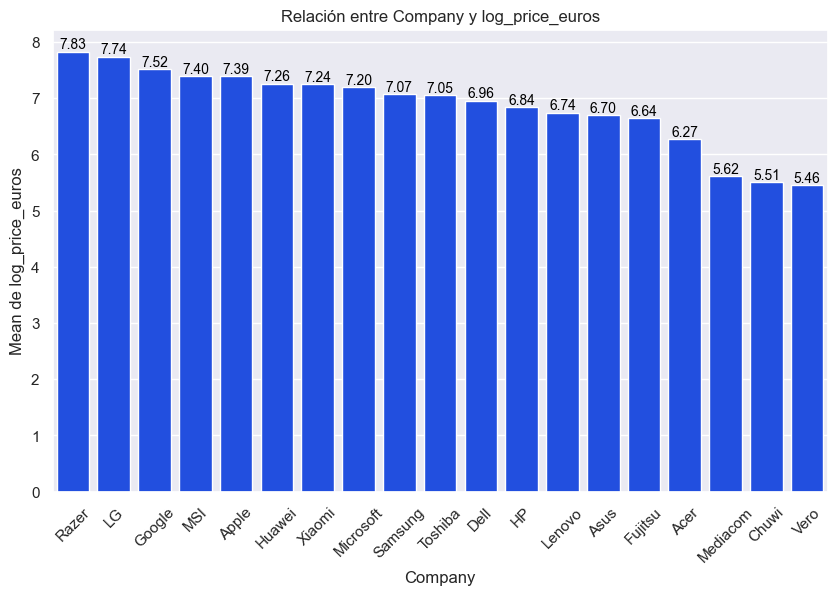

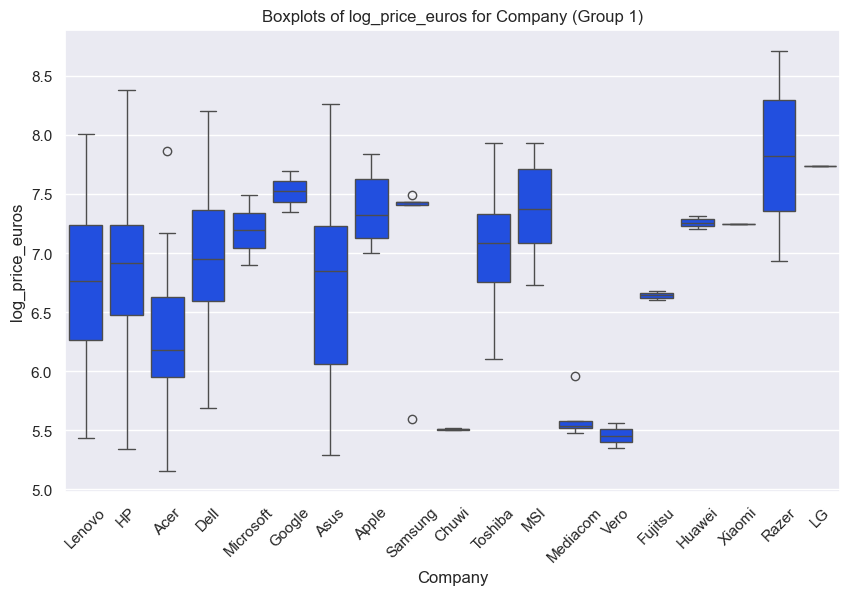

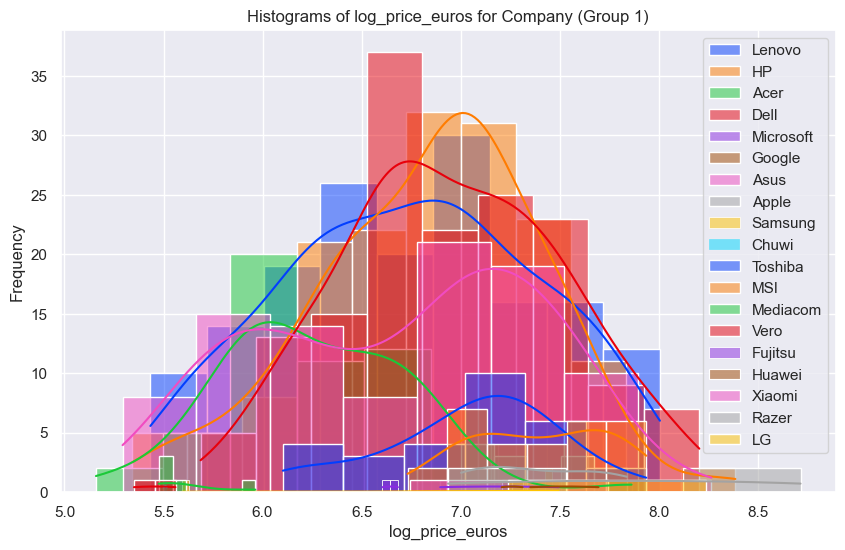

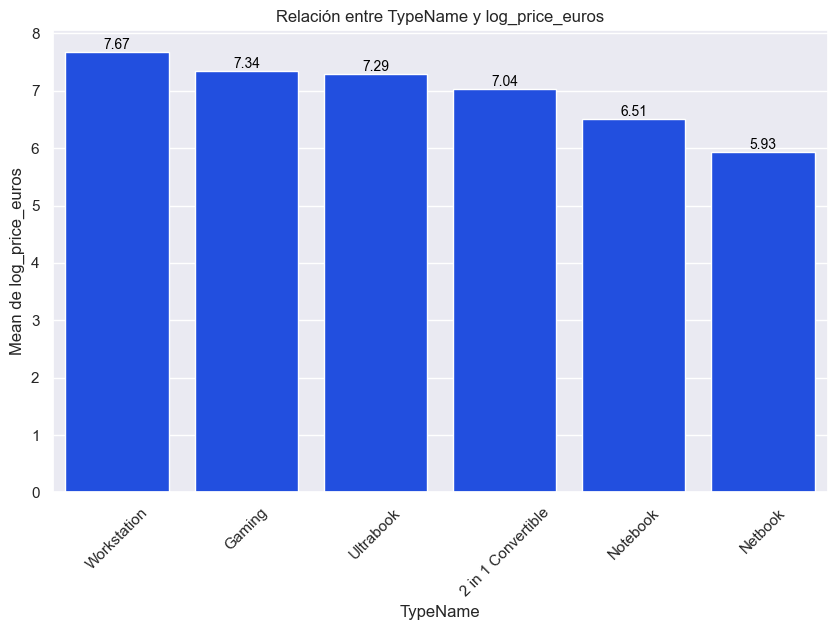

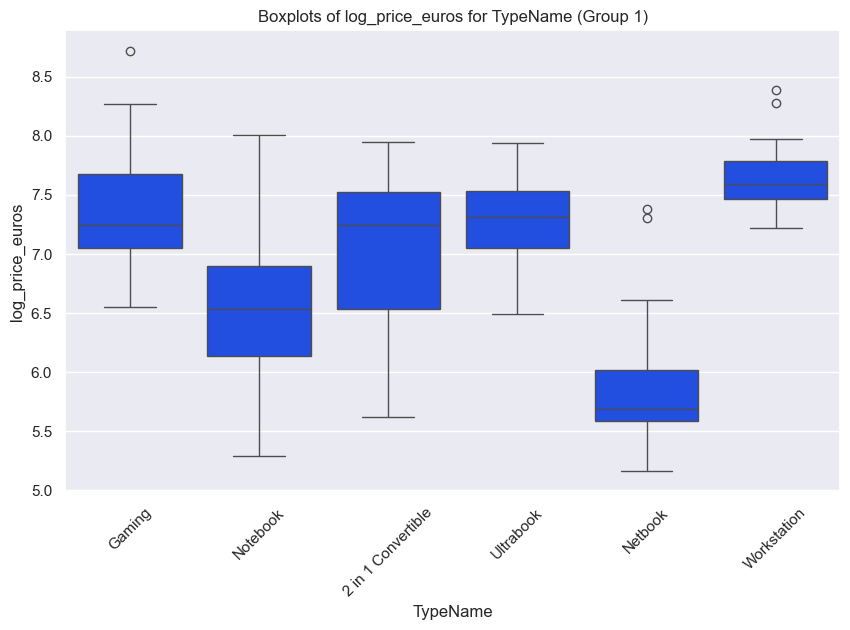

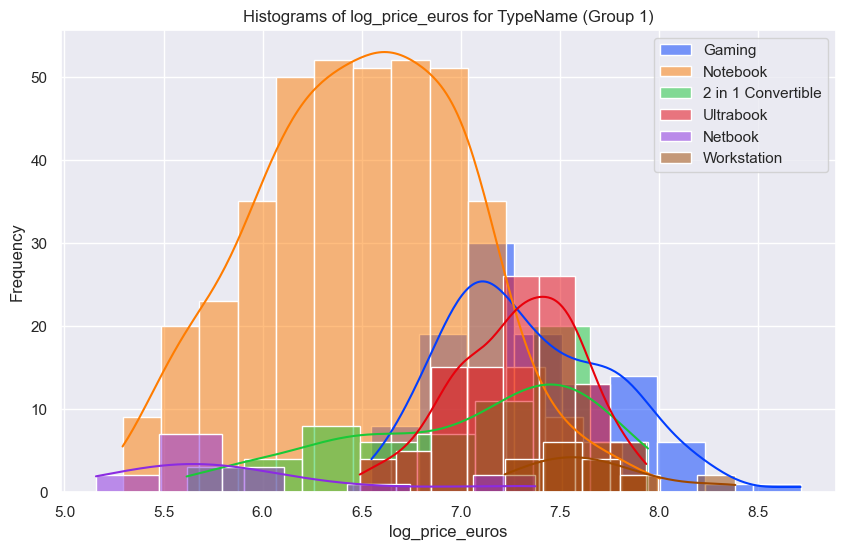

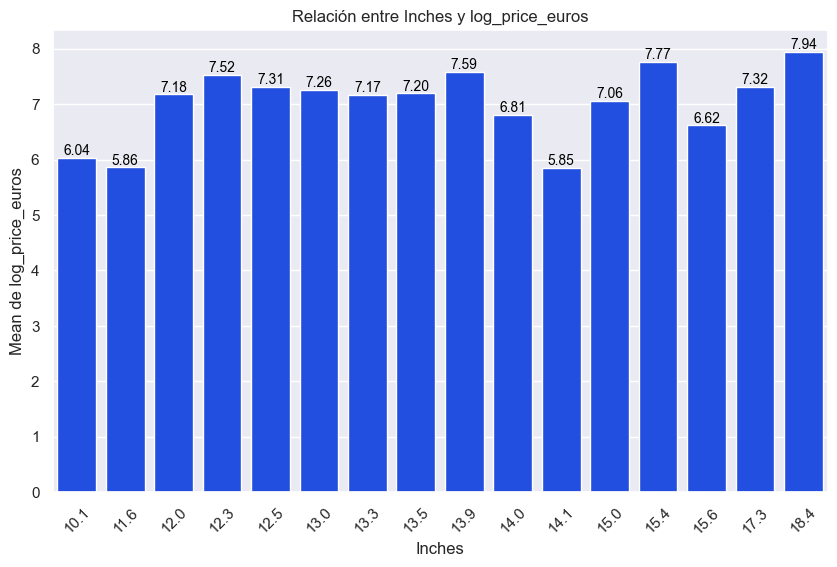

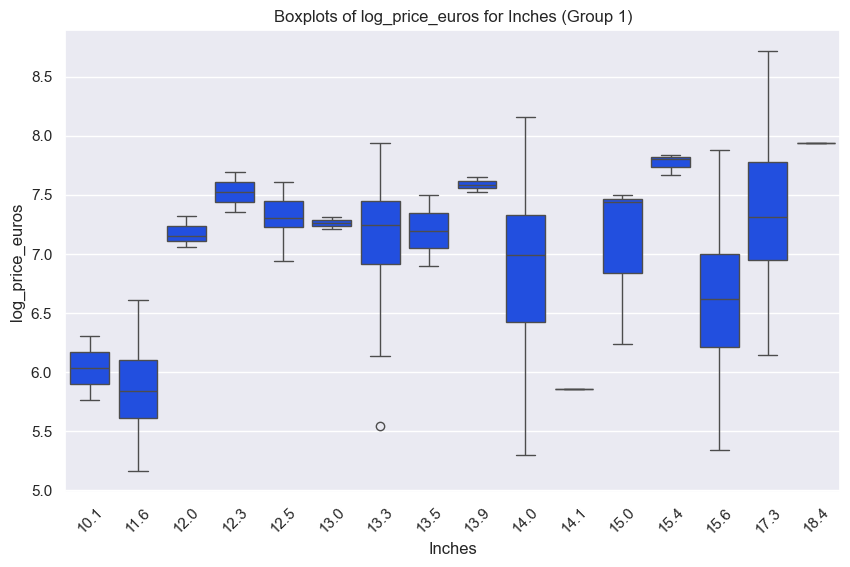

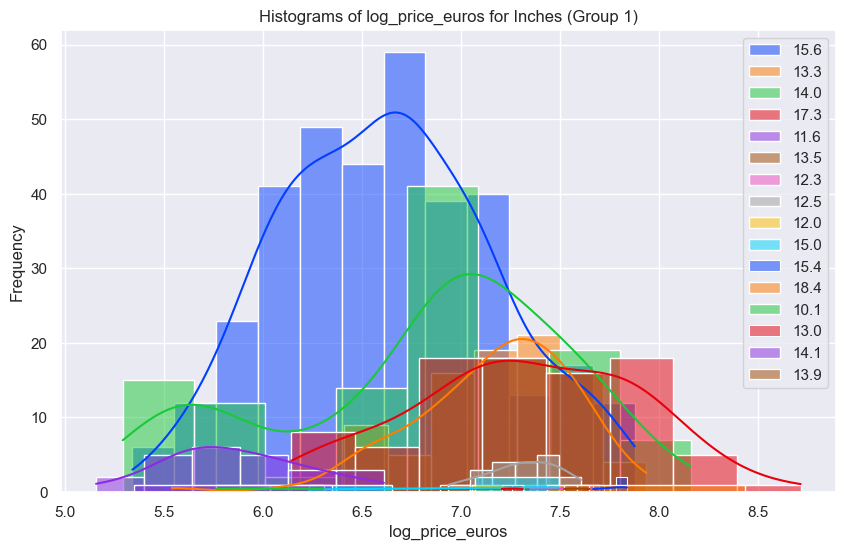

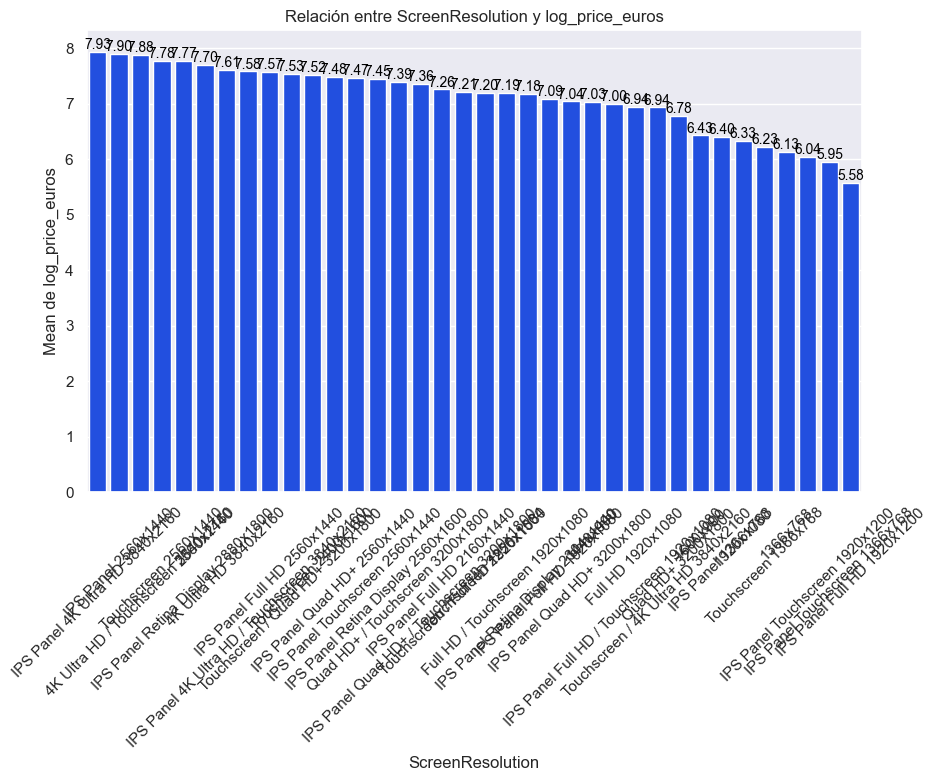

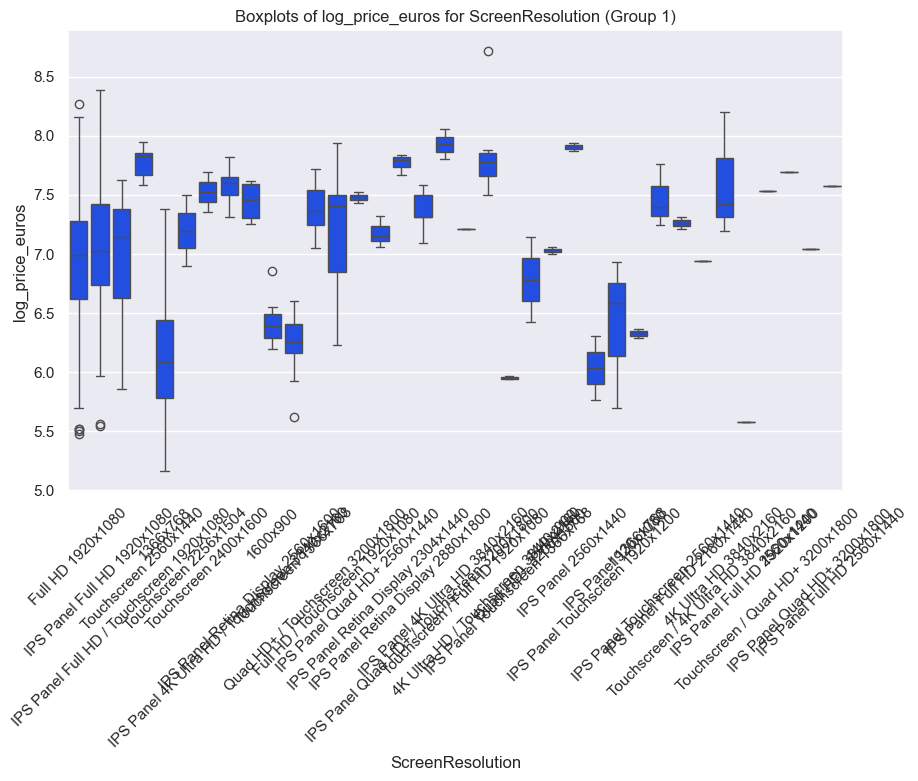

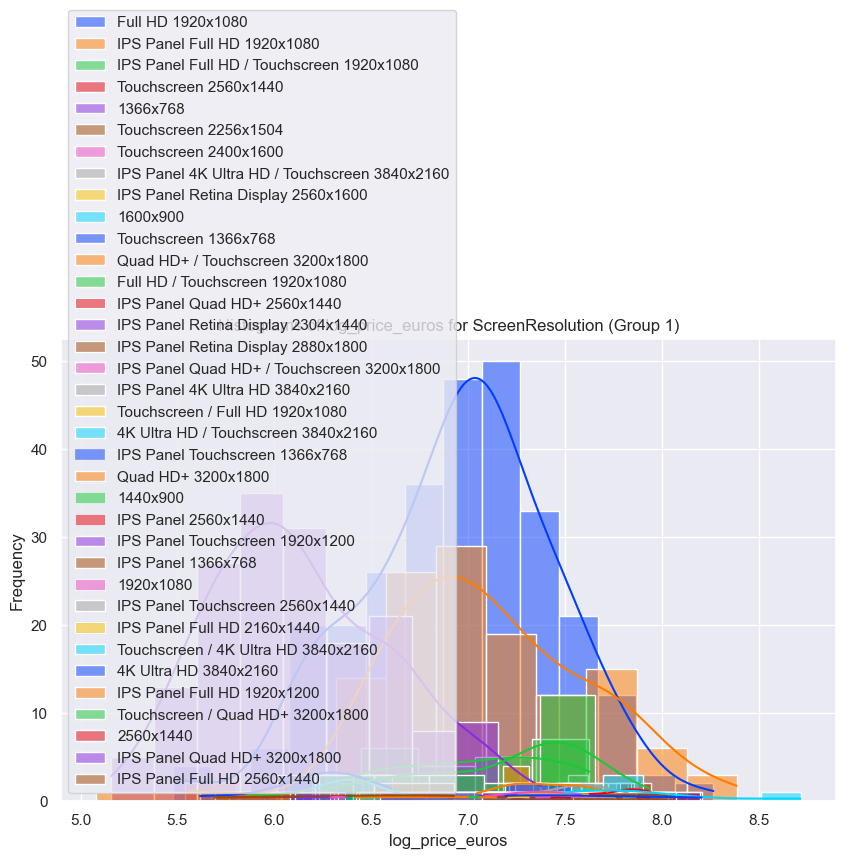

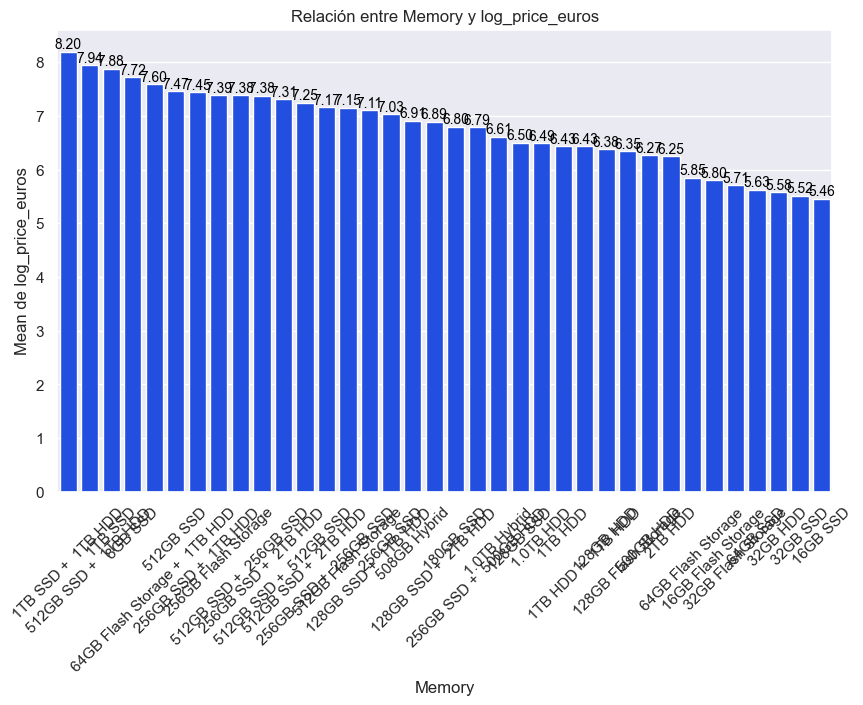

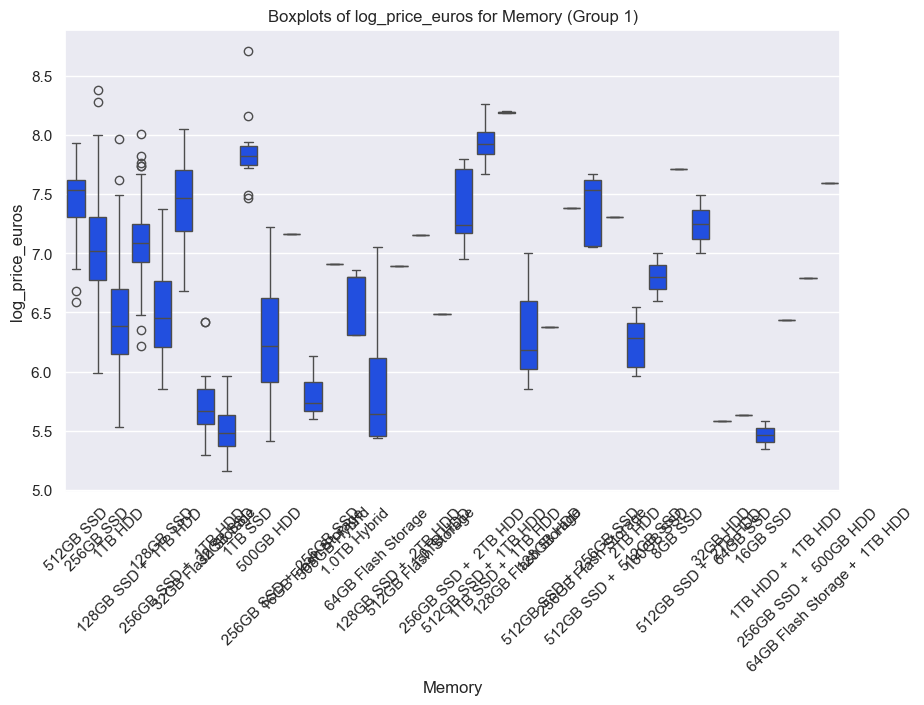

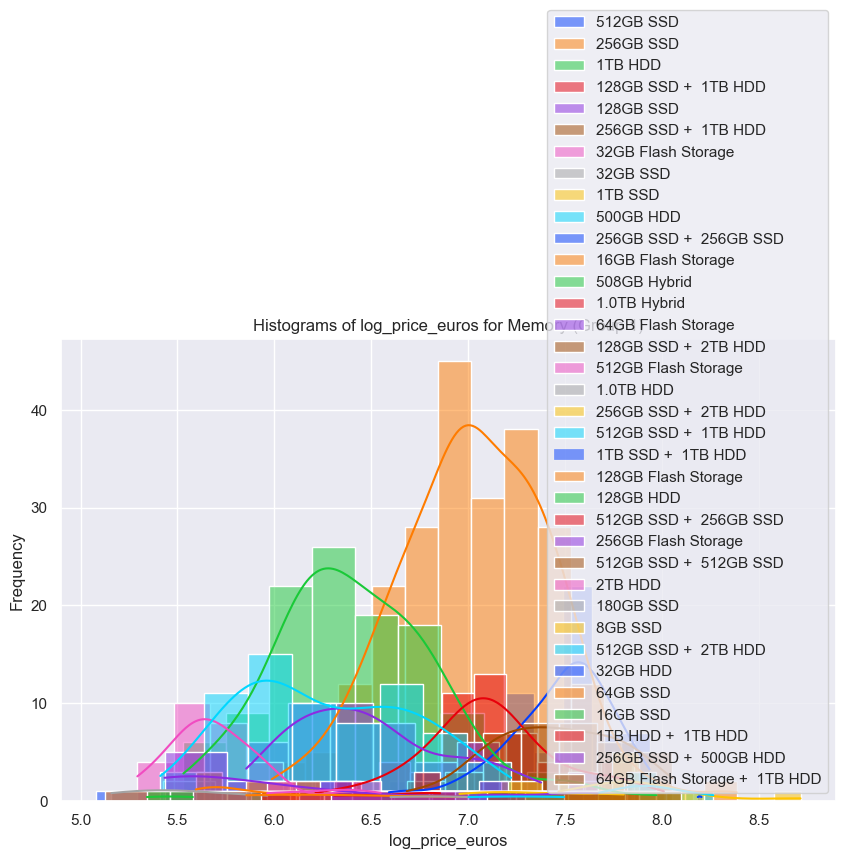

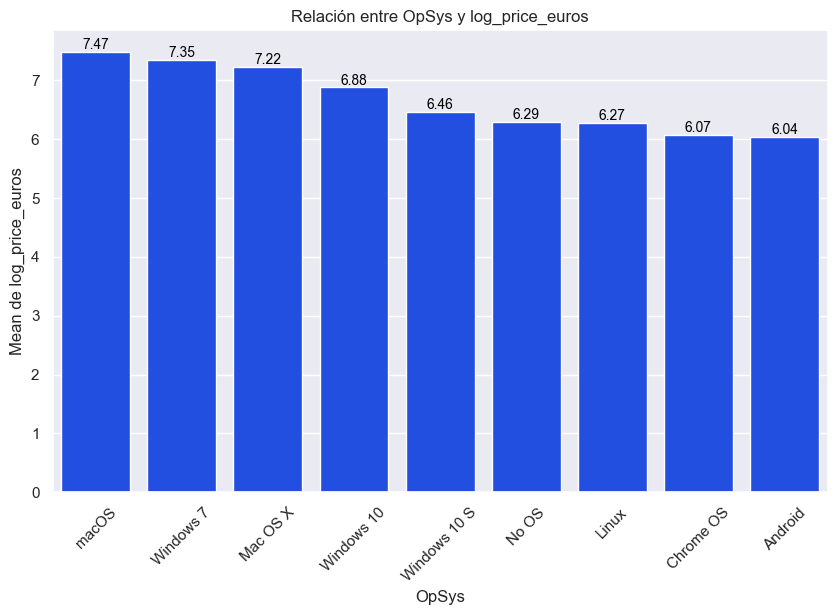

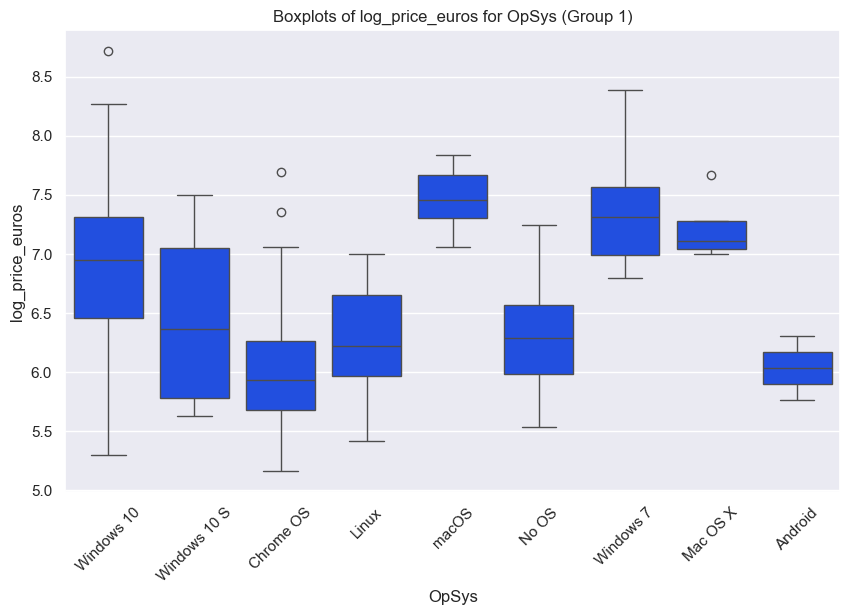

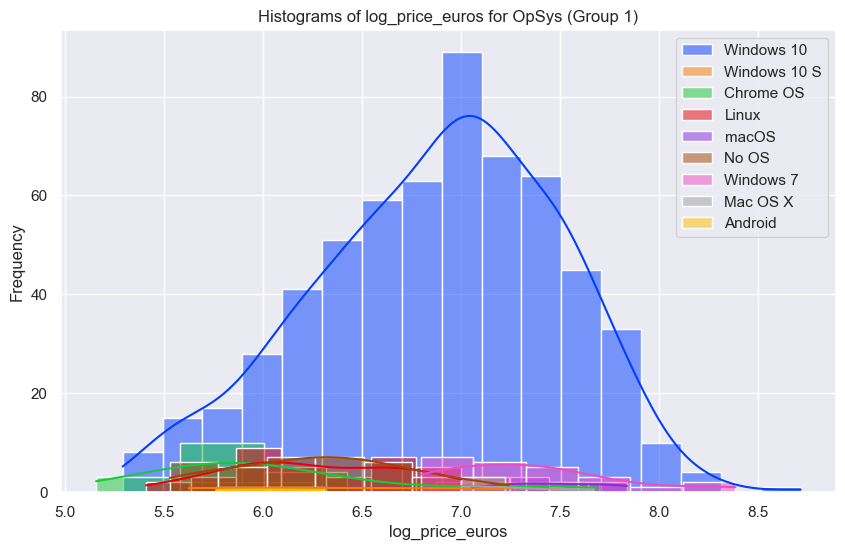

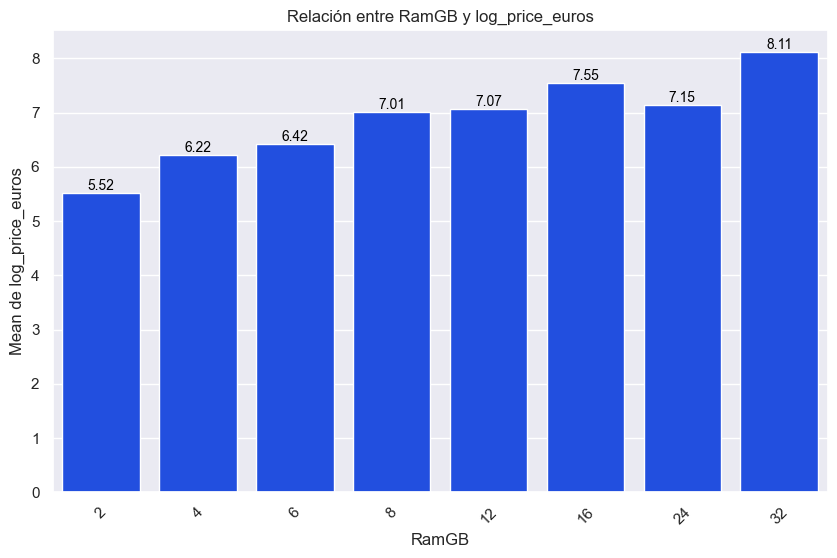

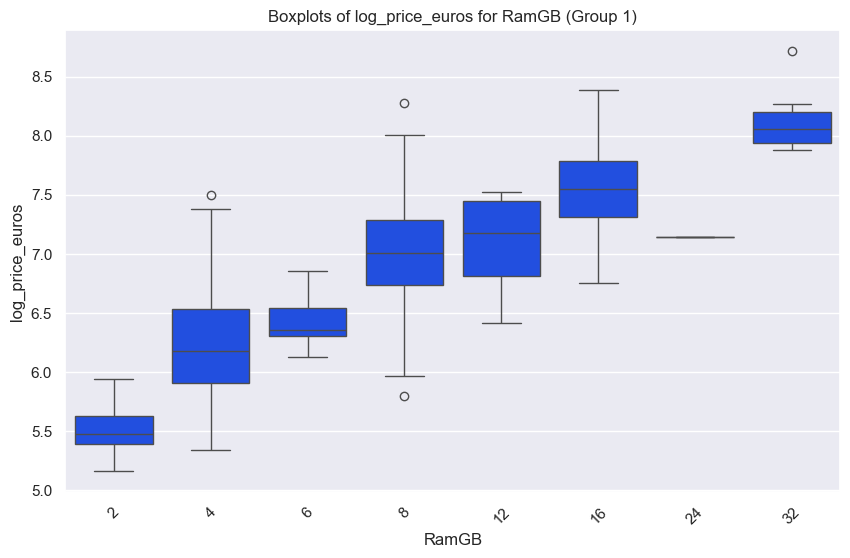

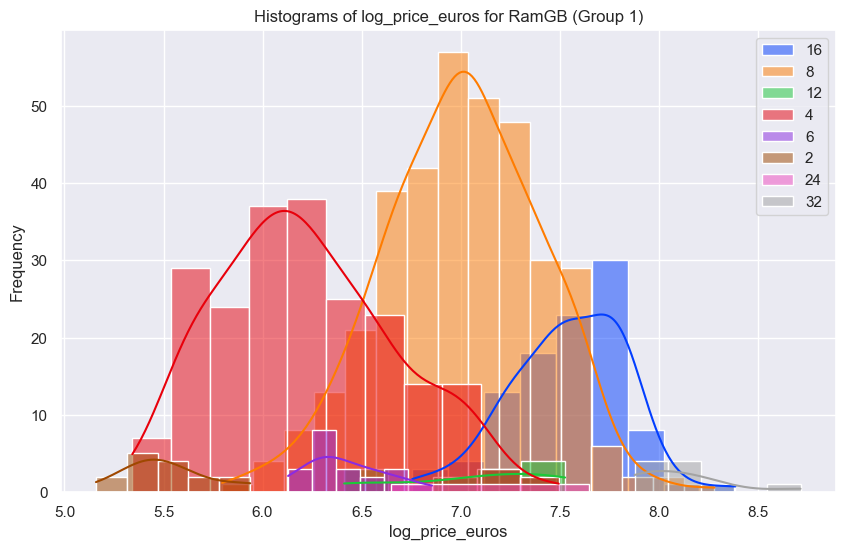

In [19]:
for cat_feature in cat_features:
    if cat_feature not in cat_features_high_card:
        viz.plot_categorical_numerical_relationship(train_set, cat_feature, target, group_size=cat_max_nunique)
        viz.boxplots_grouped(train_set, cat_feature, target, group_size=cat_max_nunique)
        viz.plot_histograms_grouped(train_set, cat_feature, target, group_size=cat_max_nunique)
    

Es algo complicado y lento de analizar visualmente pero todas me parecen interesantes.

Lo único que puedo resaltar es que hay algunos valores de outliers, condicionados a la clase a la que pertecen, que también podría eliminar para que mi modelo generalice mejor, pero de nuevo, `aquí no voy a eliminar más outliers`. Puede que en futuros modelos sí lo haga.

# Variables numéricas

Voy a hacer ahora un análisis de correlación con el *target* de las variables representadas numéricamente (que no es lo mismo que decir que son numéricas), y de colinealidad, porque puedo sacar nuevas conclusiones.

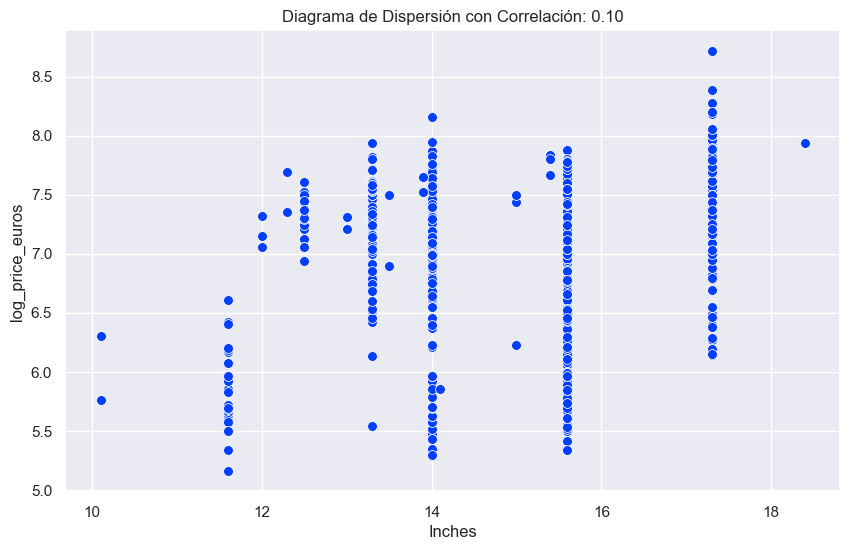

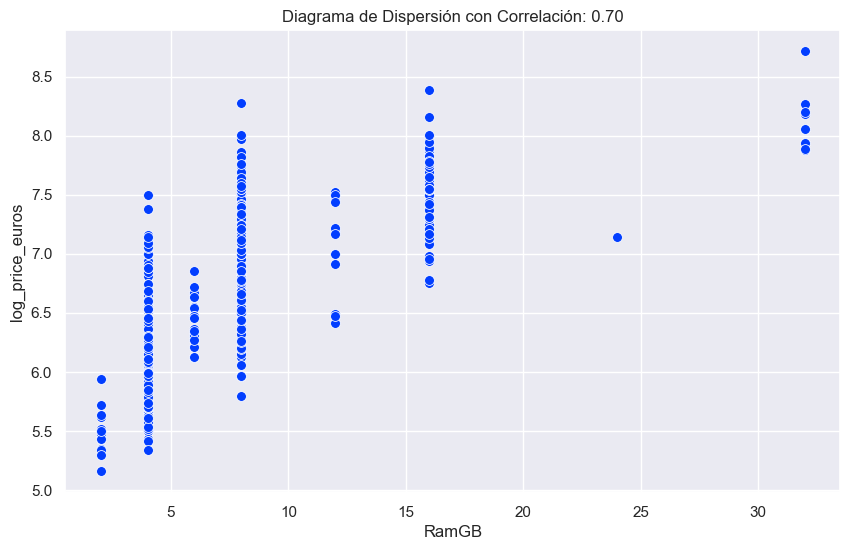

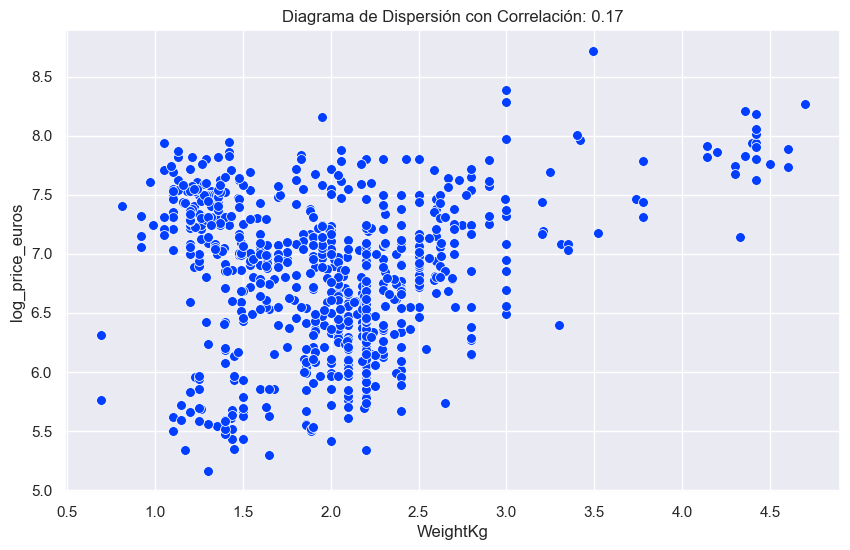

In [20]:
for col in ['Inches', 'RamGB', 'WeightKg']:
    viz.scatterplot_with_correlation(train_set, col, target)

<Axes: >

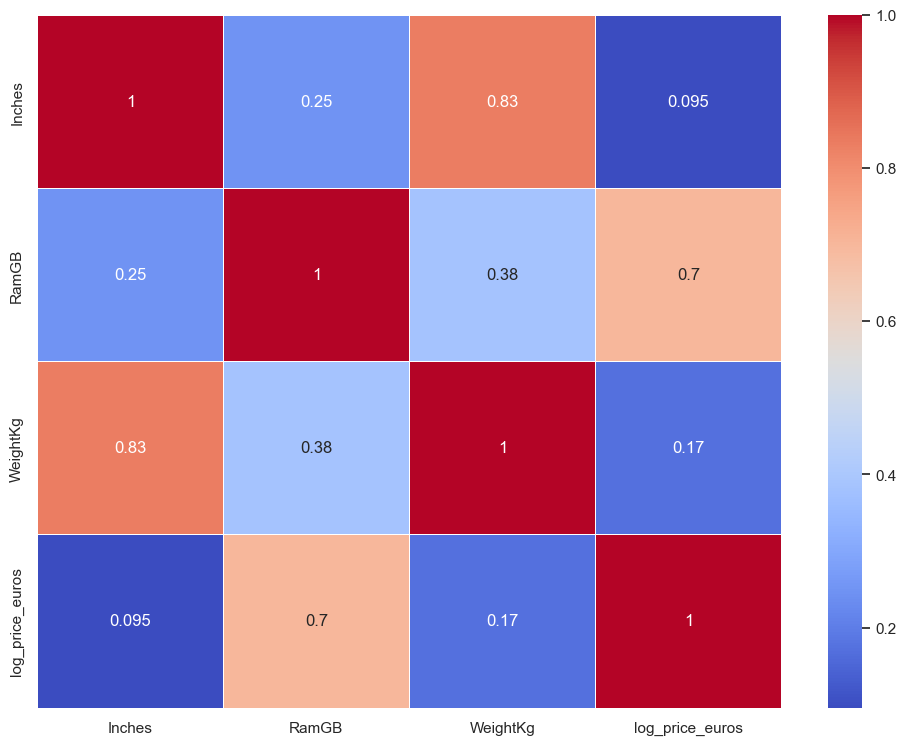

In [21]:
corr_matrix = train_set.corr(numeric_only=True)
plt.subplots(figsize=(12,9))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, linewidths=0.5)

Conclusiones de esta matriz de correlaciones:

- Si trato "RamGB" como una numérica discreta, encuentro que tiene una alta correlación con "Price_in_euro", y puede que sea más conveniente que tratarla como una categórica.
- A su vez, si hago la anterior suposición, encuentro que "RamGB" y "WeightKg" tienen una alta colinealidad, lo que puede hacer que sea con dependedientes el resultado de la regresión mejore eliminando esta segunda. Aunque no tanto como WeightKg con Inches (0.84)

Todas las conclusiones que he sacado hasta este punto van a servir para probar diferentes features, tratarlas de diferente forma y probar varios modelos de regresión.

# 5. Transformación de features


Para este set voy a considerar "Inches" y "WeightKg" como numéricas discretas y me las voy a cargar por su baja correlación con el target

In [22]:
train_set.drop(columns=['Inches', 'WeightKg'], inplace=True)
valid_set.drop(columns=['Inches', 'WeightKg'], inplace=True)

In [23]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 729 entries, 1119 to 1028
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           729 non-null    object 
 1   TypeName          729 non-null    object 
 2   ScreenResolution  729 non-null    object 
 3   Cpu               729 non-null    object 
 4   Memory            729 non-null    object 
 5   Gpu               729 non-null    object 
 6   OpSys             729 non-null    object 
 7   RamGB             729 non-null    int32  
 8   log_price_euros   729 non-null    float64
dtypes: float64(1), int32(1), object(7)
memory usage: 54.1+ KB


In [24]:
X_train = train_set.drop(columns=[target])
y_train = train_set[target]

X_valid = valid_set.drop(columns=[target])
y_valid = valid_set[target]

De momento no voy a hacer tranformaciones porque voy a usar modelos a los que no les importa estar estandarizados. Y voy a intentar aprovecharme de algoritmos que usen directamente categóricas.

# 6. Instanciación de modelos

In [25]:
# Convertir a listas de índices de las columnas categóricas
# cat_features = [X_train.columns.get_loc(feature) for feature in cat_features]
cat_features = list(range(len(X_train.columns)))
cat_features

[0, 1, 2, 3, 4, 5, 6, 7]

In [26]:
# Qué GPU puedo usar para entrenar CatBoost
from catboost.utils import get_gpu_device_count
print('I see %i GPU devices' % get_gpu_device_count())


I see 1 GPU devices


In [27]:
# Instanciar modelos

# CatBoost implemented on GPU
cat_reg = CatBoostRegressor(cat_features=cat_features)

In [28]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 729 entries, 1119 to 1028
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Company           729 non-null    object
 1   TypeName          729 non-null    object
 2   ScreenResolution  729 non-null    object
 3   Cpu               729 non-null    object
 4   Memory            729 non-null    object
 5   Gpu               729 non-null    object
 6   OpSys             729 non-null    object
 7   RamGB             729 non-null    int32 
dtypes: int32(1), object(7)
memory usage: 48.4+ KB


### CatBoostRegressor

In [29]:
# Ajustar hiperparámetros con GridSearchCV
kwargs = {
    'scoring': 'neg_root_mean_squared_error', 
    'cv': 10, 
    'verbose': True,
    'n_jobs': 10
}

param_grid = {
    'iterations': [2000, 3000],
    'depth': [4, 5, 6, 7],
    'learning_rate': [0.01, 0.03, 0.07, 0.1],
    'l2_leaf_reg': [1, 2, 3, 4],
    'bagging_temperature': [1],
    'colsample_bylevel': [None]
}

cat_grid = GridSearchCV(estimator=cat_reg, 
                        param_grid=param_grid, 
                        **kwargs
                        )

start_time = time.time()

cat_grid.fit(X_train, y_train)

end_time = time.time()
print(f'Tiempo de ejecución: {round((end_time-start_time)/60, 1)} minutos.')

# Guardar modelos con "pickle"
os.makedirs('models', exist_ok=True)
with open('./models/cat_grid_lap01_ouliers_new_feats.pkl', 'wb') as file:
    pickle.dump(cat_grid, file)

Fitting 10 folds for each of 128 candidates, totalling 1280 fits


c:\Users\Lander\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


0:	learn: 0.6292807	total: 174ms	remaining: 5m 48s
1:	learn: 0.6186011	total: 196ms	remaining: 3m 15s
2:	learn: 0.6087152	total: 214ms	remaining: 2m 22s
3:	learn: 0.5984609	total: 232ms	remaining: 1m 55s
4:	learn: 0.5886591	total: 250ms	remaining: 1m 39s
5:	learn: 0.5791189	total: 265ms	remaining: 1m 28s
6:	learn: 0.5699688	total: 280ms	remaining: 1m 19s
7:	learn: 0.5610973	total: 295ms	remaining: 1m 13s
8:	learn: 0.5526223	total: 308ms	remaining: 1m 8s
9:	learn: 0.5443712	total: 324ms	remaining: 1m 4s
10:	learn: 0.5364895	total: 338ms	remaining: 1m 1s
11:	learn: 0.5280106	total: 353ms	remaining: 58.4s
12:	learn: 0.5204236	total: 367ms	remaining: 56.1s
13:	learn: 0.5130174	total: 382ms	remaining: 54.2s
14:	learn: 0.5060543	total: 400ms	remaining: 53s
15:	learn: 0.4997575	total: 415ms	remaining: 51.5s
16:	learn: 0.4925332	total: 430ms	remaining: 50.1s
17:	learn: 0.4853061	total: 443ms	remaining: 48.8s
18:	learn: 0.4786248	total: 456ms	remaining: 47.6s
19:	learn: 0.4724962	total: 471ms	r

Mejor modelo: <catboost.core.CatBoostRegressor object at 0x0000022E9C04B650>
Mejores hiperparámetros: {'bagging_temperature': 1, 'colsample_bylevel': None, 'depth': 6, 'iterations': 2000, 'l2_leaf_reg': 4, 'learning_rate': 0.03}
Mejor score: 0.2244649319533331
RMSE en el conjunto de train: 239.32691746058677
RMSE en el conjunto de validation: 301.1468415145148


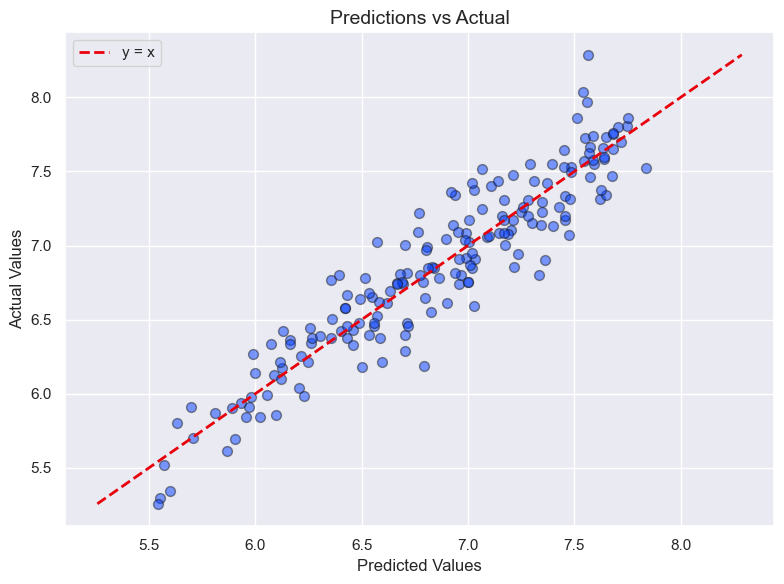

In [30]:
# CatBoost, GridSearchCV, stats

with open('./models/cat_grid_lap01_ouliers_new_feats.pkl', 'rb') as file:
    cat_grid = pickle.load(file)

print(f"Mejor modelo: {cat_grid.best_estimator_}")
print(f"Mejores hiperparámetros: {cat_grid.best_params_}")
print(f"Mejor score: {-cat_grid.best_score_}")

# Predecir en el conjunto de train
y_pred = cat_grid.best_estimator_.predict(X_train)
rmse = root_mean_squared_error(np.exp(y_train), np.exp(y_pred))
print(f"RMSE en el conjunto de train: {rmse}")

# Predecir en el conjunto de validación
y_pred = cat_grid.best_estimator_.predict(X_valid)
rmse = root_mean_squared_error(np.exp(y_valid), np.exp(y_pred))
print(f"RMSE en el conjunto de validation: {rmse}")

ml.plot_predictions_vs_actual(y_valid, y_pred)

# 7. Predicción sobre set de Kaggle.

En este apartado cargamos el "test.csv" de Kaggle sobre el que se van a hacer las predicciones para competición. Hay que hacerle todas las transformaciones que se han hecho al conjunto de train.

In [31]:
# Volver a cargar el set para Train y 
train_set = pd.read_csv(r'data/train.csv', index_col=0)

# Eliminar ['Product', 'Inches', 'WeightKg']
train_set.drop(columns=['Product', 'Inches', 'Weight'], inplace=True)

# Transformar las columnas "Ram" y "Weight" a numéricas y eliminar las originales
train_set['RamGB'] = train_set['Ram'].str.replace('GB', '').astype(int)
train_set.drop(['Ram'], axis=1, inplace=True)

# Aplicar logaritmo al target
train_set['log_price_euros'] = np.log(train_set['Price_in_euros'])

target = 'log_price_euros'
X_train = train_set.drop(columns=['Price_in_euros', target])
y_train = train_set[target]

In [32]:
# Cargar test set
X_test = pd.read_csv(r'data/test.csv', index_col=0)

# Eliminar ['Product', 'Inches', 'WeightKg']
X_test.drop(columns=['Product', 'Inches', 'Weight'], inplace=True)

# Transformar las columnas "Ram" y "Weight" a numéricas y eliminar las originales
X_test['RamGB'] = X_test['Ram'].str.replace('GB', '').astype(int)
X_test.drop(['Ram'], axis=1, inplace=True)


In [33]:
# Volver a entrenar el modelo
with open('./models/cat_grid_lap01_ouliers_new_feats.pkl', 'rb') as file:
    cat_grid = pickle.load(file)

cat_best_model = cat_grid.best_estimator_
cat_best_model.fit(X_train, y_train)

0:	learn: 0.6212996	total: 10.8ms	remaining: 21.6s
1:	learn: 0.6103087	total: 31.2ms	remaining: 31.2s
2:	learn: 0.5999532	total: 48.5ms	remaining: 32.3s
3:	learn: 0.5897779	total: 67.4ms	remaining: 33.6s
4:	learn: 0.5795889	total: 91.8ms	remaining: 36.6s
5:	learn: 0.5698188	total: 112ms	remaining: 37.2s
6:	learn: 0.5596830	total: 130ms	remaining: 37.1s
7:	learn: 0.5509170	total: 152ms	remaining: 37.8s
8:	learn: 0.5420632	total: 171ms	remaining: 37.8s
9:	learn: 0.5341857	total: 207ms	remaining: 41.2s
10:	learn: 0.5257125	total: 224ms	remaining: 40.5s
11:	learn: 0.5177762	total: 245ms	remaining: 40.6s
12:	learn: 0.5100869	total: 264ms	remaining: 40.4s
13:	learn: 0.5030842	total: 279ms	remaining: 39.6s
14:	learn: 0.4953681	total: 297ms	remaining: 39.3s
15:	learn: 0.4884626	total: 316ms	remaining: 39.1s
16:	learn: 0.4817876	total: 334ms	remaining: 39s
17:	learn: 0.4750872	total: 353ms	remaining: 38.9s
18:	learn: 0.4687143	total: 372ms	remaining: 38.8s
19:	learn: 0.4621283	total: 390ms	rema

In [34]:
pred_cat = np.exp(cat_best_model.predict(X_test))

In [35]:
submission_cat_grid_lap01_ouliers_new_feats = pd.DataFrame({'laptop_ID': X_test.index, 
                                       'Price_in_euros': pred_cat})

In [36]:
submission_cat_grid_lap01_ouliers_new_feats.head()

,laptop_ID,Price_in_euros
0,209,1350.766131
1,1281,282.086171
2,1168,345.601017
3,1231,1303.446197
4,1020,798.539704


In [37]:
kaggle_checker(submission_cat_grid_lap01_ouliers_new_feats, 
               path=r'./submissions/submission_cat_grid_lap01_ouliers_new_feats.csv'
               )

You're ready to submit!


### Eliminar "Product"